In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder


In [2]:
train_path = 'amex-default-prediction/train.parquet'
test_path = 'amex-default-prediction/test.parquet'
labels_path = 'amex-default-prediction/train_labels.csv'
train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)
labels = pd.read_csv(labels_path)
train = train.merge(labels, left_on='customer_ID', right_on='customer_ID')


In [4]:
# train["ones"] = 1
# sums = train.groupby("customer_ID").sum()
# sums[(sums["target"] != sums["ones"]) & (sums["target"] > 0)]

In [5]:
test.head(10)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0,0.010728,0.814497,0.0,0.168651,0.0,0.002347,...,-1,-1,-1,-1,0,NaN,NaN,-1,0.008281,-1
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0,0.011026,0.810848,0.0,0.241389,0.0,0.009132,...,-1,-1,-1,0,0,0.0,NaN,0,0.003753,0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0,0.016390,1.004620,0.0,0.266976,0.0,0.004192,...,-1,-1,-1,0,0,0.0,NaN,0,0.002156,0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614911,0,0.021672,0.816549,0.0,0.188947,0.0,0.015325,...,-1,-1,-1,0,0,0.0,NaN,0,0.005206,0
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591673,8,0.015923,0.810456,0.0,0.180035,0.0,0.011281,...,-1,-1,-1,0,0,0.0,NaN,0,0.007421,0
5,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-07-13,0.587472,0,0.007959,1.001009,0.0,0.173701,0.0,0.009779,...,-1,-1,-1,0,0,0.0,NaN,0,0.009667,0
6,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-08-16,0.625006,8,0.013420,0.816605,0.0,0.170644,0.0,0.019999,...,-1,-1,-1,0,0,0.0,NaN,0,0.005664,0
7,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-09-29,0.597074,0,0.017426,1.000670,0.0,0.158006,0.0,0.011962,...,-1,-1,-1,0,0,0.0,NaN,0,0.005733,0
8,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-10-12,0.568930,4,0.010779,1.009347,0.0,0.149413,0.0,0.003576,...,-1,-1,-1,0,0,0.0,NaN,0,0.003690,0
9,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,2018-04-22,0.894195,11,0.020970,1.001803,0.0,0.073243,0.0,0.001597,...,-1,-1,-1,0,0,0.0,NaN,0,0.008436,0


In [6]:
test.shape

(11363762, 190)

In [7]:
len(test['customer_ID'].unique())

924621

In [8]:
test.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,1.130388e+07,1.136376e+07,1.136376e+07,1.136084e+07,1.136376e+07,9.622797e+06,1.136084e+07,1.136084e+07,1.357583e+06,7.951136e+06,...,1.136376e+07,1.136376e+07,1.136376e+07,1.136376e+07,1.136376e+07,1.126606e+07,1.966795e+06,1.136376e+07,1.133992e+07,1.136376e+07
mean,6.576891e-01,5.143341e+00,1.279497e-01,6.167635e-01,7.043231e-02,2.274023e-01,5.479387e-02,1.433976e-01,1.480857e-01,1.619003e-01,...,-9.379195e-01,-9.678666e-01,-9.584572e-01,1.645107e-01,2.056106e-02,1.614486e-01,4.068860e-01,1.643901e-01,5.198748e-02,6.323916e-01
std,2.455860e-01,9.035258e+00,2.044189e-01,3.974260e-01,2.098478e-01,1.956999e-01,1.962996e-01,2.422445e-01,2.509171e-01,2.100530e-01,...,3.719659e-01,1.778998e-01,2.466158e-01,3.932455e-01,1.559448e-01,3.333823e-01,2.483099e-01,3.931425e-01,1.780295e-01,2.166812e+00
min,-4.658552e-01,0.000000e+00,-7.057416e+00,2.125048e-10,0.000000e+00,-6.855620e-01,0.000000e+00,4.880305e-10,-5.467810e-04,8.992179e-09,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.471698e-02,-1.000000e+00,1.051329e-09,-1.000000e+00
25%,4.863303e-01,0.000000e+00,9.505715e-03,9.869011e-02,0.000000e+00,1.265055e-01,0.000000e+00,5.502882e-03,2.361050e-02,4.430551e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.005020e-01,0.000000e+00,2.753515e-03,0.000000e+00
50%,6.987661e-01,0.000000e+00,3.335463e-02,8.143016e-01,0.000000e+00,1.642667e-01,0.000000e+00,1.065161e-02,7.822216e-02,9.430225e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.950928e-01,0.000000e+00,5.504539e-03,0.000000e+00
75%,8.649260e-01,8.000000e+00,1.344752e-01,1.002716e+00,0.000000e+00,2.621010e-01,0.000000e+00,1.806050e-01,1.809862e-01,1.967024e-01,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.944293e-01,0.000000e+00,8.254793e-03,0.000000e+00
max,1.010000e+00,3.170000e+02,1.324060e+00,1.010000e+00,3.258507e+00,4.341215e+00,1.211718e+01,1.698651e+00,4.191158e+00,1.249030e+01,...,7.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.320065e+00,2.280940e+00,1.000000e+00,1.343333e+00,6.000000e+01


In [9]:
categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

test['S_2'] = pd.to_datetime(test['S_2'])
test[categorical_features] = test[categorical_features].astype("category")

In [10]:
test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), datetime64[ns](1), float32(93), int16(10), int8(74), object(1)
memory usage: 5.2+ GB


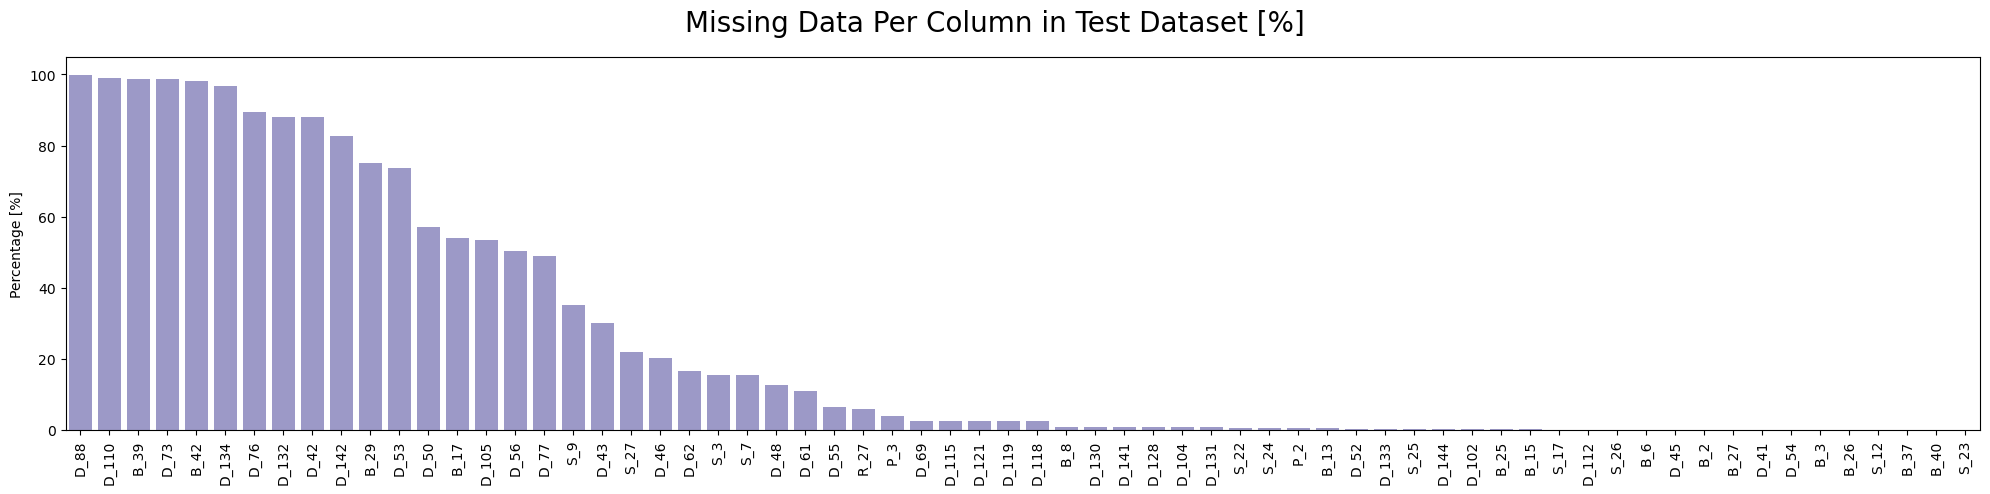

In [11]:
temp = test.isna().sum().div(len(test)).mul(100).sort_values(ascending = False)
temp = temp[temp != 0]

fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(x=temp.index, y=temp.values, ax=ax, color='#7A76C2', alpha = 0.8)
ax.set_ylabel('Percentage [%]')
ax.tick_params(axis='x', rotation=90)
plt.suptitle("Missing Data Per Column in Test Dataset [%]", fontsize = 20)
plt.tight_layout()
plt.show()

del temp
_ = gc.collect()

In [12]:
print(f'Test dates range is from {test.S_2.min()} to {test.S_2.max()} spanning aduration of {test.S_2.max() - test.S_2.min()}.')

Test dates range is from 2018-04-01 00:00:00 to 2019-10-31 00:00:00 spanning aduration of 578 days 00:00:00.


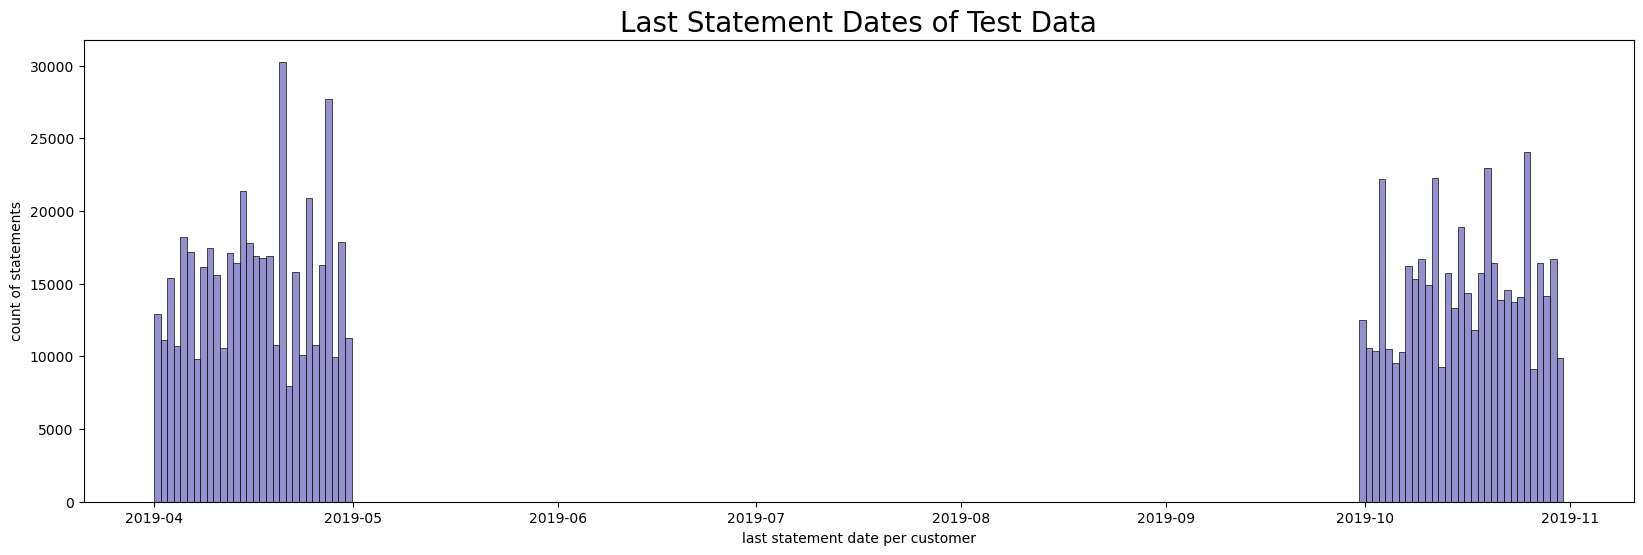

In [13]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
temp = test.S_2.groupby(test.customer_ID).max().reset_index().sort_values('S_2').set_index('customer_ID')
sns.histplot(x='S_2', data=temp, bins=len(pd.date_range(temp.min()[0], temp.max()[0], freq="d")), ax=ax,  color='#7A76C2', alpha = 0.8)
ax.set_title('Last Statement Dates of Test Data', fontsize=20)
ax.set_xlabel('last statement date per customer')
ax.set_ylabel('count of statements')
plt.show()

del temp
_ = gc.collect()

In [14]:
print(f'Number of unique customers in test data: {test["customer_ID"].nunique()}')


Number of unique customers in test data: 924621


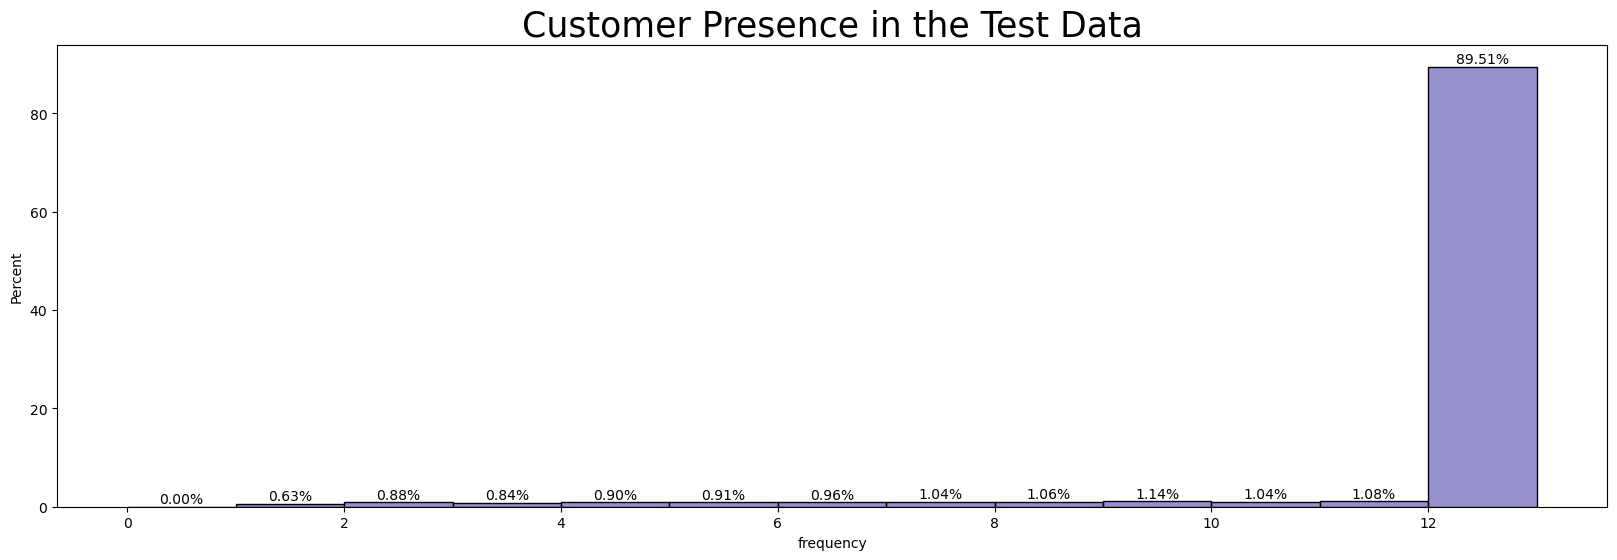

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
temp = test.groupby(['customer_ID']).size().reset_index().rename(columns={0:'frequency'})
sns.histplot(x='frequency', stat='percent', bins=np.arange(0,14), data=temp, ax=ax, color='#7A76C2', alpha = 0.8)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.set_title('Customer Presence in the Test Data', fontsize = 25)
plt.show()

del temp
_ = gc.collect()

In [16]:
#assign types
train['S_2'] = pd.to_datetime(train['S_2'])
train[categorical_features] = train[categorical_features].astype("category")

In [17]:
train.shape

(5531451, 191)

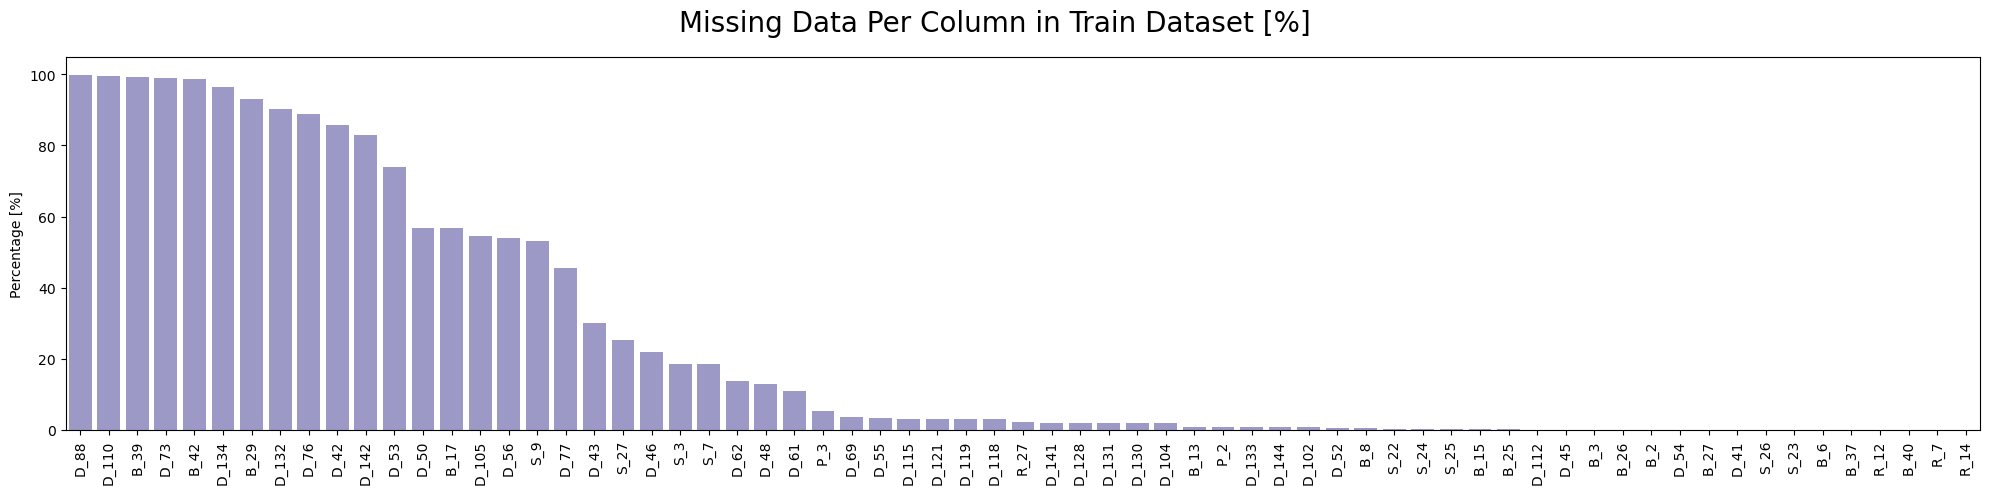

In [18]:
temp = train.isna().sum().div(len(train)).mul(100).sort_values(ascending = False)
temp = temp[temp != 0]

fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(x=temp.index, y=temp.values, ax=ax, color='#7A76C2', alpha=0.8)
ax.set_ylabel('Percentage [%]')
ax.tick_params(axis='x', rotation=90)
plt.suptitle("Missing Data Per Column in Train Dataset [%]", fontsize = 20)
plt.tight_layout()
plt.show()

del temp
_ = gc.collect()

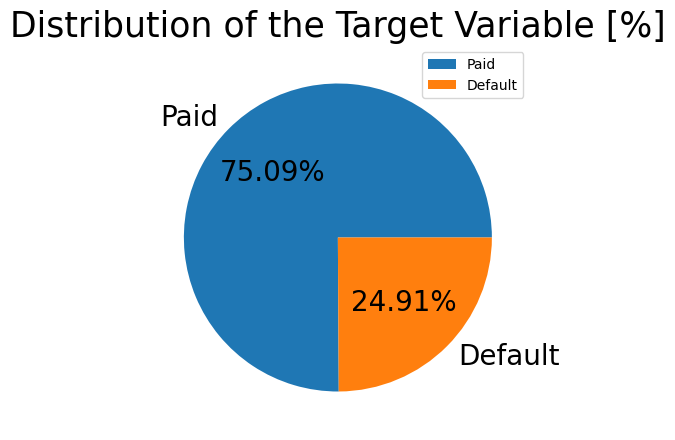

In [19]:
temp = train['target'].value_counts()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.pie(temp.values, labels=['Paid', 'Default'], textprops={'fontsize': 20}, autopct='%.2f%%' )
plt.legend()
plt.title('Distribution of the Target Variable [%]',fontsize=25)
plt.show()

del temp
_ = gc.collect()

In [20]:
print(f'Train dates range is from {train.S_2.min()} to {train.S_2.max()} spanning aduration of {train.S_2.max() - train.S_2.min()}.')

Train dates range is from 2017-03-01 00:00:00 to 2018-03-31 00:00:00 spanning aduration of 395 days 00:00:00.


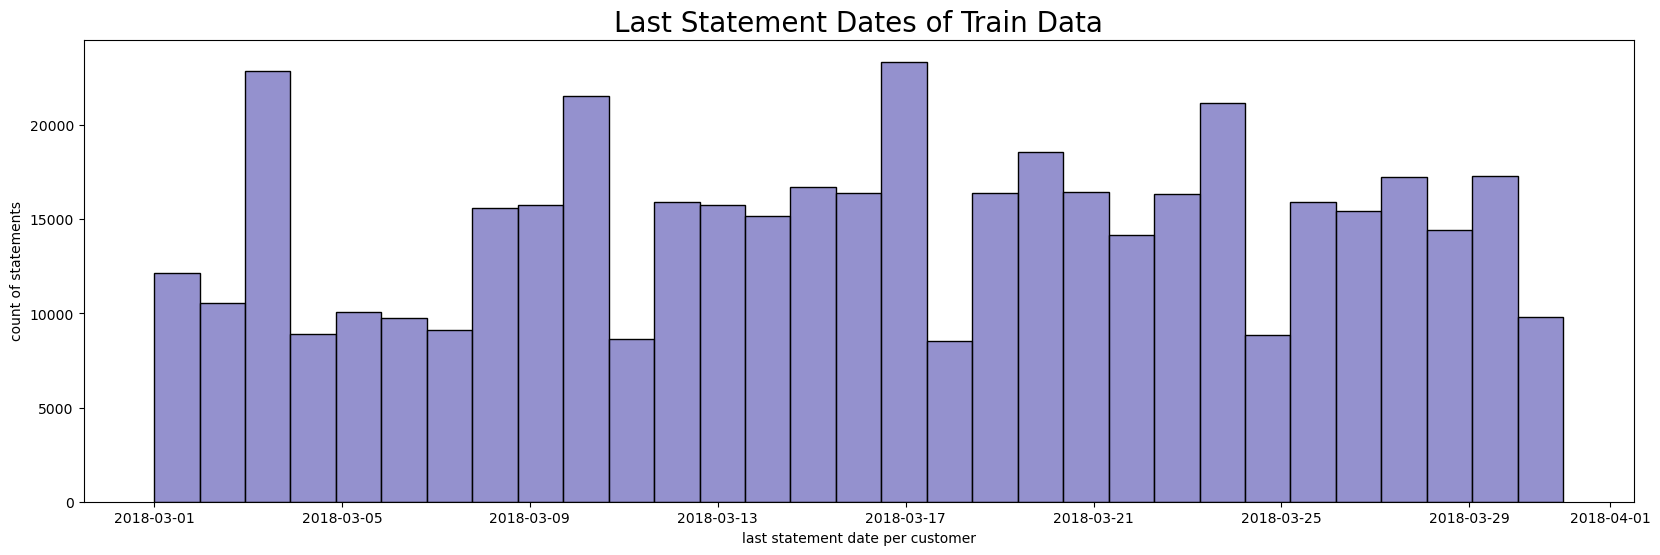

In [21]:
#last month statement
fig, ax = plt.subplots(1,1, figsize=(20,6))
temp = train.S_2.groupby(train.customer_ID).max().reset_index().sort_values('S_2').set_index('customer_ID')
sns.histplot(x='S_2', data=temp, bins=len(pd.date_range(temp.min()[0], temp.max()[0], freq="d")), ax=ax, color='#7A76C2', alpha=0.8)
ax.set_title('Last Statement Dates of Train Data', fontsize=20)
ax.set_xlabel('last statement date per customer')
ax.set_ylabel('count of statements')
plt.show()

del temp
_ = gc.collect()

In [22]:
print(f'Number of unique customers in train data: {train["customer_ID"].nunique()}')

Number of unique customers in train data: 458913


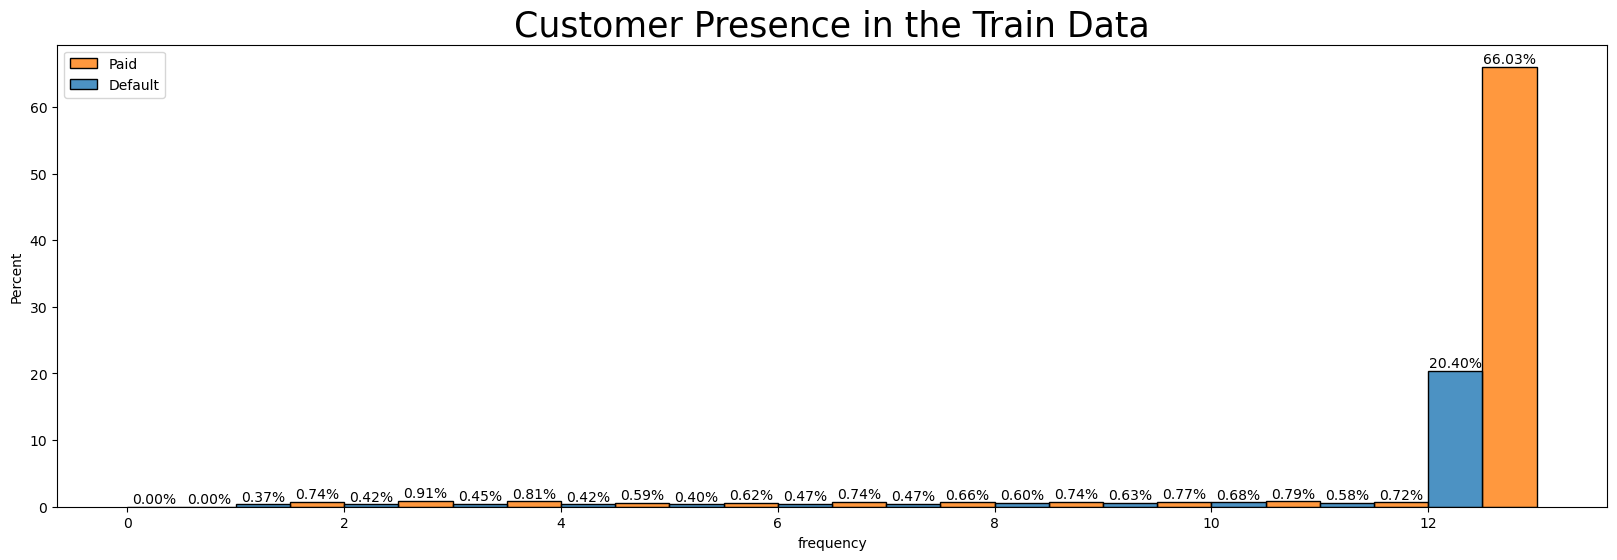

In [23]:
#number of unique customers and their presence in train data
fig, ax = plt.subplots(1,1, figsize=(20,6))
temp = train.groupby(['customer_ID', 'target']).size().reset_index().rename(columns={0:'frequency'})
sns.histplot(x='frequency',hue='target',hue_order=[1,0], stat='percent', bins=np.arange(0,14), data=temp, ax=ax, multiple='dodge',alpha = 0.8)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_title('Customer Presence in the Train Data', fontsize = 25)
ax.legend(loc=0, labels=['Paid','Default'])
plt.show()

del temp
_ = gc.collect()

In [25]:
train_last = train.groupby('customer_ID').tail(1).reset_index(drop=True)
train_last.shape

(458913, 191)

In [26]:
train_last.groupby('customer_ID').count()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,1,1,1,1,1,1,0,1,1,0,...,1,1,1,1,1,0,1,1,1,1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,1,1,1,1,1,1,0,1,1,0,...,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,1,1,1,1,1,1,0,1,1,0,...,1,1,1,1,1,0,1,1,1,1
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1


In [27]:
train.head(20)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,0,0,0.0,NaN,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,0,0,0.0,NaN,0,0.008126,0,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0,0.007863,1.005006,0.004220,0.110946,0.0,0.009866,...,-1,-1,0,0,0.0,NaN,0,0.002223,0,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0,0.018859,1.008024,0.004509,0.103329,0.0,0.000783,...,-1,-1,0,0,0.0,NaN,0,0.007661,0,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0,0.014324,1.000242,0.000263,0.108115,0.0,0.007836,...,-1,-1,0,0,0.0,NaN,0,0.009616,0,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0,0.016888,1.003995,0.001789,0.102792,0.0,0.009817,...,-1,-1,0,0,0.0,NaN,0,0.004369,0,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,0,0,0.0,NaN,0,0.004753,0,0


In [28]:
# cols = [c for c in train_last.columns if (c.startswith((letter,'t'))) & (c not in categorical_features) & (c != "S_2")]
# temp = train_last[cols]
# plot_cols = 4
# plot_rows = math.ceil((len(cols) - 1)/plot_cols)

# fig, axes = plt.subplots(plot_rows, plot_cols, figsize=figsize)
# for i, ax in enumerate(axes.reshape(-1)):
#     if i<len(cols)-1:
#         sns.kdeplot(x=cols[i], hue ='target', data=temp, fill=True,hue_order=[1,0], linewidth=2, 
#                     ax=ax)

In [29]:
# Keep the latest statement features for each customer
train_lastST = train.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
# Keep the latest statement features for each customer
test_lastST = test.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

Nan values

In [30]:
NaN_Val = np.array(train_lastST.isnull().sum())
NaN_prec = np.array((train_lastST.isnull().sum() * 100 / len(train)).round(2))
NaN_Col = pd.DataFrame([np.array(list(train_lastST.columns)).T,NaN_Val.T,NaN_prec.T,np.array(list(train_lastST.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)
NaN_Col

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,2969,0.05,float32
2,D_39,0,0.0,int16
3,B_1,0,0.0,float32
4,B_2,31,0.0,float32
5,R_1,0,0.0,float32
6,S_3,84970,1.54,float32
7,D_41,31,0.0,float32
8,B_3,31,0.0,float32
9,D_42,399003,7.21,float32


In [30]:
NaN_Col[NaN_Col['Percentage'] == NaN_Col['Percentage'].max()]

,Features,Num of Missing values,Percentage,DataType


In [31]:
train_lastST = train_lastST.drop(['S_2','D_66','D_42','D_49','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)
selected_col = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for col in selected_col:
    train_lastST[col] = train_lastST[col].fillna(train_lastST[col].median())

selcted_col2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for col2 in selcted_col2:
    train_lastST[col2] =  train_lastST[col2].fillna(train_lastST[col2].mode()[0])

In [33]:
print(train_lastST.isnull().sum().to_string())


P_2       0
D_39      0
B_1       0
B_2       0
R_1       0
S_3       0
D_41      0
B_3       0
D_43      0
D_44      0
B_4       0
D_45      0
B_5       0
R_2       0
D_46      0
D_47      0
D_48      0
B_6       0
B_7       0
B_8       0
D_50      0
D_51      0
B_9       0
R_3       0
D_52      0
P_3       0
B_10      0
D_53      0
S_5       0
B_11      0
S_6       0
D_54      0
R_4       0
S_7       0
B_12      0
S_8       0
D_55      0
D_56      0
B_13      0
R_5       0
D_58      0
S_9       0
B_14      0
D_59      0
D_60      0
D_61      0
B_15      0
S_11      0
D_62      0
D_63      0
D_64      0
D_65      0
B_16      0
B_17      0
B_18      0
B_19      0
B_20      0
D_68      0
S_12      0
R_6       0
S_13      0
B_21      0
D_69      0
B_22      0
D_70      0
D_71      0
D_72      0
S_15      0
B_23      0
P_4       0
D_74      0
D_75      0
B_24      0
R_7       0
D_77      0
B_25      0
B_26      0
D_78      0
D_79      0
R_8       0
S_16      0
D_80      0
R_10      0
R_11

In [34]:
NaN_Val2 = np.array(test_lastST.isnull().sum())
NaN_prec2 = np.array((test_lastST.isnull().sum() * 100 / len(test_lastST)).round(2))
NaN_Col2 = pd.DataFrame([np.array(list(test_lastST.columns)).T,NaN_Val2.T,NaN_prec2.T,np.array(list(test_lastST.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

NaN_Col2

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,4784,0.52,float32
2,D_39,0,0.0,int16
3,B_1,0,0.0,float32
4,B_2,43,0.0,float32
5,R_1,0,0.0,float32
6,S_3,144280,15.6,float32
7,D_41,43,0.0,float32
8,B_3,43,0.0,float32
9,D_42,827578,89.5,float32


In [36]:
test_lastST = test_lastST.drop(['S_2','D_42','D_49','D_66','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)
selected_column = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','S_12','S_17','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for column in selected_column:
    test_lastST[column] = test_lastST[column].fillna(test_lastST[column].median())

selected_column2 = np.array(['D_68','B_30','B_38','D_114','D_116','D_117','D_120','D_126'])

for column2 in selected_column2:
    test_lastST[column2] =  test_lastST[column2].fillna(test_lastST[column2].mode()[0])

In [38]:
enc = OrdinalEncoder()
categorical_features.remove('D_66')

train_lastST[categorical_features] = enc.fit_transform(train_lastST[categorical_features])
test_lastST[categorical_features] = enc.transform(test_lastST[categorical_features])

In [39]:
train_dataset_without_target = train_lastST.drop(["target"],axis=1)

cor_matrix = train_dataset_without_target.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
col_core

{'B_11',
 'B_13',
 'B_15',
 'B_23',
 'B_33',
 'B_37',
 'D_104',
 'D_119',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

In [40]:
train_lastST.head(1)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.092436,0,...,0.0,0.00621,0,0,0,0.0,0,0.00297,0,0


In [41]:
train_lastST = train_lastST.drop(col_core, axis=1)
test_lastST = test_lastST.drop(col_core, axis=1)

In [190]:
def lgb_model(train_df, num_columns, categorical_features):

    X = train_df[num_columns]
    y = train_df['target']

    print(f"X shape is = {X.shape}" )
    print(f"Y shape is = {y.shape}" )

    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"X_train shape is = {x_train.shape}" )
    print(f"Y_train shape is = {y_train.shape}" )
    print(f"X_test shape is = {x_test.shape}" )
    print(f"Y_test shape is = {y_test.shape}" )

    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_features)

    params = {'objective': 'binary','n_estimators': 1200,'metric': 'binary_logloss','boosting': 'gbdt','num_leaves': 90,'reg_lambda' : 50,'colsample_bytree': 0.19,'learning_rate': 0.03,'min_child_samples': 2400,'max_bins': 511,'seed': 42,'verbose': -1}

    # trained model with 100 iterations
    model = lgb.train(params, d_train, 100)
    return model

In [45]:
num_columns = [col for col in train_lastST.columns if col not in ["target"]]
predictions = lgb_model(train_lastST, num_columns, categorical_features).predict(test_lastST[num_columns])
predictions

array([0.01531914, 0.00237844, 0.04497124, ..., 0.46526616, 0.19422713,
       0.03929207])

In [46]:
#sample_dataset = pd.read_csv('amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': test_lastST.index, 'prediction': predictions})
output.to_csv('submission.csv', index=False)

In [47]:
output.head(5)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.015319
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.002378
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.044971
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.258500
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.889879


In [48]:
output.shape

(924621, 2)

In [49]:
sample_dataset = pd.read_csv('amex-default-prediction/sample_submission.csv')
sample_dataset.shape

(924621, 2)

In [229]:
def aggregate_data(df, labels):
    features = df.drop(["customer_ID", "S_2"], axis = 1).columns.to_list()
    # As described in the data tab in the competition description
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    # The rest of the features - columns are numerical features
    num_features = [col for col in features if col not in cat_features]
    
    print("Starting feature engineer on numerical features...")
    # Numerical features aggregated by time period
    df_num_agg = df.groupby("customer_ID")[num_features].agg(["mean", "std", "min", "max", "first", "last"])
    df_num_agg.columns = ["_".join(x) for x in df_num_agg.columns]
    df_num_agg.reset_index(inplace = True)
    #if there is 1 row for id then std == Nan (dividing by 1-1 = 0)
    #df_num_agg[[col for col in df_num_agg.columns if 'std' in col]].fillna(0, inplace=True)
    
    print("Starting feature engineer on lag features...")
    # Lag Features: First / Last interactions
    # for col in df_num_agg.columns:
    #     if 'last' in col and col.replace('last', 'first') in df_num_agg.columns:
            
    #         df_num_agg[col + "_lag_sub"] = df_num_agg[col] - df_num_agg[col.replace("last", "first")]
    #         df_num_agg[col + "_lag_div"] = df_num_agg[col] / df_num_agg[col.replace("last", "first")]

    print("Starting feature engineer on categorical features...")
    # Categorical features aggregated by time period
    #df_cat_agg = df.groupby("customer_ID")[cat_features].agg([pd.Series.mode, "count", "first", "last", "nunique"])
    df_cat_agg = df.groupby("customer_ID")[cat_features].agg([ "count", "first", "last", "nunique"])
    df_cat_agg.columns = ["_".join(x) for x in df_cat_agg.columns]
    df_cat_agg.reset_index(inplace = True)
    
    if labels is not None: 
        df_agg = df_num_agg.merge(df_cat_agg, how = "inner", on = "customer_ID").merge(labels, how = 'inner', on = 'customer_ID')
    else:
        df_agg = df_num_agg.merge(df_cat_agg, how = "inner", on = "customer_ID")
    return df_agg

In [152]:
NaN_Val2 = np.array(train.isnull().sum())
NaN_prec2 = np.array((train.isnull().sum() * 100 / len(train)).round(2))
NaN_Col2 = pd.DataFrame([np.array(list(train.columns)).T,NaN_Val2.T,NaN_prec2.T,np.array(list(train.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

#NaN_Col2

In [153]:
train = train.drop(np.array(NaN_Col2[NaN_Col2['Percentage'] >= 80]['Features']), axis=1)
selected_col = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for col in selected_col:
    train[col] = train[col].fillna(train[col].median())

selcted_col2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for col2 in selcted_col2:
    train[col2] =  train[col2].fillna(train[col2].mode()[0])

In [154]:
print(train.isnull().sum().unique())


[0]


In [156]:
#test = test.drop(np.array(NaN_Col2[NaN_Col2['Percentage'] >= 80]['Features']), axis=1)
selected_column = np.array(['P_2','S_3','B_2', 'D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','S_12','S_17','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for column in selected_column:
    test[column] = test[column].fillna(test[column].median())

selected_column2 = np.array(['D_68','B_30','B_38','D_114','D_116','D_117','D_120','D_126'])

for column2 in selected_column2:
    test[column2] =  test[column2].fillna(test[column2].mode()[0])

In [157]:
test.isnull().sum()[test.isnull().sum() != 0] 

Series([], dtype: int64)

In [159]:
enc = OrdinalEncoder()
#categorical_features.remove('D_66')

train[categorical_features] = enc.fit_transform(train[categorical_features])
test[categorical_features] = enc.transform(test[categorical_features])

In [160]:
print(train.shape)
print(test.shape)

(5531451, 180)
(11363762, 179)


In [230]:
train_agg = aggregate_data(train.loc[:, train.columns != 'target'], labels)

Starting feature engineer on numerical features...
Starting feature engineer on lag features...
Starting feature engineer on categorical features...


In [231]:
train_agg.head(5)

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_first,P_2_last,D_39_mean,D_39_std,D_39_min,...,D_64_nunique,D_66_count,D_66_first,D_66_last,D_66_nunique,D_68_count,D_68_first,D_68_last,D_68_nunique,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.024194,0.868580,0.960384,0.938469,0.934745,0.230769,0.832050,0,...,1,13,-1,-1,1,13,7.0,7.0,1,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.899820,0.022119,0.861109,0.929122,0.929122,0.880519,7.153846,6.743468,0,...,1,13,-1,-1,1,13,7.0,7.0,1,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878454,0.028911,0.797670,0.904482,0.876615,0.880875,0.000000,0.000000,0,...,1,13,-1,-1,1,13,7.0,7.0,1,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.598969,0.020107,0.567442,0.623392,0.567442,0.621776,1.538462,3.017046,0,...,1,13,-1,-1,1,13,3.0,4.0,3,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.891679,0.042325,0.805045,0.940382,0.936842,0.871900,0.000000,0.000000,0,...,1,13,1,1,1,13,7.0,7.0,1,0


In [232]:
train_agg.shape

(458913, 1042)

In [233]:
for col in train_agg.columns:
    if 'std' in col:
        train_agg[col] = train_agg[col].fillna(0)

In [234]:
train_agg.isna().sum().sum()

0

In [235]:
test_agg = aggregate_data(test, None)

Starting feature engineer on numerical features...
Starting feature engineer on lag features...
Starting feature engineer on categorical features...


In [236]:
for col in test_agg.columns:
    if 'std' in col:
        test_agg[col] = test_agg[col].fillna(0)

In [237]:
test_agg.shape

(924621, 1041)

In [238]:
test_agg.isna().sum().sum()

0

In [239]:
train_agg.set_index('customer_ID', inplace=True)
test_agg.set_index('customer_ID', inplace=True)

In [240]:
cat_features = [col for col in train_agg.columns if 'mode' in col]
cat_features

[]

In [241]:
# for col in cat_features:
#     train_agg[col] = train_agg[col].astype(str)
#     test_agg[col] = test_agg[col].astype(str)
# enc = OrdinalEncoder()
# #categorical_features.remove('D_66')

# train_agg[cat_features] = enc.fit_transform(train_agg[cat_features])
# test_agg[cat_features] = enc.transform(test_agg[cat_features])

In [242]:
num_columns = [col for col in train_agg.columns if col not in ["target"]]
predictions = lgb_model(train_agg, num_columns, []).predict(test_agg[num_columns])
predictions

X shape is = (458913, 1040)
Y shape is = (458913,)
X_train shape is = (367130, 1040)
Y_train shape is = (367130,)
X_test shape is = (91783, 1040)
Y_test shape is = (91783,)


/Users/tetiana/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/tetiana/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


array([0.01397256, 0.00078484, 0.0298437 , ..., 0.38095093, 0.26183611,
       0.0376095 ])

In [243]:
output = pd.DataFrame({'customer_ID': test_agg.index, 'prediction': predictions})
output.to_csv('submission_agg_version.csv', index=False)

In [244]:
output.shape

(924621, 2)

In [245]:
output.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.013973
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000785
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.029844
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.200820
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.822797
